# 4.1 word2vec 개선  ①

In [1]:
import numpy as np
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = [1,0,3,0]

W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [5]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self,idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        
        # for i, word_id in enumerate(self.idx):
        # dW[word_id] += dout[i]
        np.add.at(dW, self.idx, dout)
            
        return None

# 4.2 word2vec 개선 ②

In [6]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [7]:
np.random.choice(10)

4

In [8]:
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'you'

In [9]:
np.random.choice(words, size = 5)

array(['goodbye', 'I', 'you', 'I', 'say'], dtype='<U7')

In [10]:
np.random.choice(words, size = 5, replace =False)

array(['goodbye', 'say', 'I', 'hello', '.'], dtype='<U7')

In [11]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

In [12]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [13]:
import collections
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        

        return negative_sample

In [14]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[4 2]
 [0 2]
 [1 4]]


In [15]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

# 4.3 개선판 word2vec 학습

In [16]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 2[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 5[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 8[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 10[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 13[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 16[s] | loss 3.77
| epoch 1 |  iter 141 / 9295 | time 18[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 21[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 24[s] | loss 3.35
| epoch 1 |  iter 201 / 9295 | time 26[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 29[s] | loss 3.16
| epoch 1 |  iter 241 / 9295 | time 32[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 34[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 37[s] | loss 2.95
| epoch 1 |  iter 301 / 9295 | time 40[s] | loss 2.92
| epoch 1 |  iter 321 / 9295 | time 43[s] | loss 2.86
| epoch 1 |  iter 341 / 9295 | time 45[s] | loss 2.82
| epoch 1 |  iter 361 / 9295 | time 48

| epoch 1 |  iter 2981 / 9295 | time 407[s] | loss 2.46
| epoch 1 |  iter 3001 / 9295 | time 409[s] | loss 2.44
| epoch 1 |  iter 3021 / 9295 | time 412[s] | loss 2.45
| epoch 1 |  iter 3041 / 9295 | time 415[s] | loss 2.44
| epoch 1 |  iter 3061 / 9295 | time 418[s] | loss 2.44
| epoch 1 |  iter 3081 / 9295 | time 420[s] | loss 2.43
| epoch 1 |  iter 3101 / 9295 | time 423[s] | loss 2.43
| epoch 1 |  iter 3121 / 9295 | time 426[s] | loss 2.44
| epoch 1 |  iter 3141 / 9295 | time 428[s] | loss 2.47
| epoch 1 |  iter 3161 / 9295 | time 431[s] | loss 2.43
| epoch 1 |  iter 3181 / 9295 | time 434[s] | loss 2.43
| epoch 1 |  iter 3201 / 9295 | time 437[s] | loss 2.43
| epoch 1 |  iter 3221 / 9295 | time 440[s] | loss 2.41
| epoch 1 |  iter 3241 / 9295 | time 444[s] | loss 2.42
| epoch 1 |  iter 3261 / 9295 | time 447[s] | loss 2.44
| epoch 1 |  iter 3281 / 9295 | time 450[s] | loss 2.43
| epoch 1 |  iter 3301 / 9295 | time 453[s] | loss 2.44
| epoch 1 |  iter 3321 / 9295 | time 456[s] | lo

| epoch 1 |  iter 5921 / 9295 | time 819[s] | loss 2.32
| epoch 1 |  iter 5941 / 9295 | time 821[s] | loss 2.29
| epoch 1 |  iter 5961 / 9295 | time 824[s] | loss 2.31
| epoch 1 |  iter 5981 / 9295 | time 827[s] | loss 2.33
| epoch 1 |  iter 6001 / 9295 | time 829[s] | loss 2.29
| epoch 1 |  iter 6021 / 9295 | time 832[s] | loss 2.33
| epoch 1 |  iter 6041 / 9295 | time 835[s] | loss 2.30
| epoch 1 |  iter 6061 / 9295 | time 837[s] | loss 2.32
| epoch 1 |  iter 6081 / 9295 | time 840[s] | loss 2.37
| epoch 1 |  iter 6101 / 9295 | time 843[s] | loss 2.32
| epoch 1 |  iter 6121 / 9295 | time 845[s] | loss 2.34
| epoch 1 |  iter 6141 / 9295 | time 848[s] | loss 2.33
| epoch 1 |  iter 6161 / 9295 | time 851[s] | loss 2.31
| epoch 1 |  iter 6181 / 9295 | time 853[s] | loss 2.33
| epoch 1 |  iter 6201 / 9295 | time 856[s] | loss 2.30
| epoch 1 |  iter 6221 / 9295 | time 859[s] | loss 2.31
| epoch 1 |  iter 6241 / 9295 | time 862[s] | loss 2.30
| epoch 1 |  iter 6261 / 9295 | time 865[s] | lo

| epoch 1 |  iter 8821 / 9295 | time 1214[s] | loss 2.26
| epoch 1 |  iter 8841 / 9295 | time 1217[s] | loss 2.24
| epoch 1 |  iter 8861 / 9295 | time 1219[s] | loss 2.21
| epoch 1 |  iter 8881 / 9295 | time 1222[s] | loss 2.23
| epoch 1 |  iter 8901 / 9295 | time 1225[s] | loss 2.24
| epoch 1 |  iter 8921 / 9295 | time 1227[s] | loss 2.23
| epoch 1 |  iter 8941 / 9295 | time 1230[s] | loss 2.21
| epoch 1 |  iter 8961 / 9295 | time 1233[s] | loss 2.24
| epoch 1 |  iter 8981 / 9295 | time 1236[s] | loss 2.23
| epoch 1 |  iter 9001 / 9295 | time 1238[s] | loss 2.21
| epoch 1 |  iter 9021 / 9295 | time 1241[s] | loss 2.25
| epoch 1 |  iter 9041 / 9295 | time 1244[s] | loss 2.20
| epoch 1 |  iter 9061 / 9295 | time 1247[s] | loss 2.22
| epoch 1 |  iter 9081 / 9295 | time 1249[s] | loss 2.21
| epoch 1 |  iter 9101 / 9295 | time 1252[s] | loss 2.23
| epoch 1 |  iter 9121 / 9295 | time 1255[s] | loss 2.22
| epoch 1 |  iter 9141 / 9295 | time 1257[s] | loss 2.24
| epoch 1 |  iter 9161 / 9295 |

| epoch 2 |  iter 2421 / 9295 | time 1609[s] | loss 2.12
| epoch 2 |  iter 2441 / 9295 | time 1611[s] | loss 2.14
| epoch 2 |  iter 2461 / 9295 | time 1614[s] | loss 2.11
| epoch 2 |  iter 2481 / 9295 | time 1617[s] | loss 2.15
| epoch 2 |  iter 2501 / 9295 | time 1619[s] | loss 2.17
| epoch 2 |  iter 2521 / 9295 | time 1622[s] | loss 2.13
| epoch 2 |  iter 2541 / 9295 | time 1625[s] | loss 2.12
| epoch 2 |  iter 2561 / 9295 | time 1628[s] | loss 2.17
| epoch 2 |  iter 2581 / 9295 | time 1630[s] | loss 2.11
| epoch 2 |  iter 2601 / 9295 | time 1633[s] | loss 2.11
| epoch 2 |  iter 2621 / 9295 | time 1636[s] | loss 2.13
| epoch 2 |  iter 2641 / 9295 | time 1639[s] | loss 2.13
| epoch 2 |  iter 2661 / 9295 | time 1642[s] | loss 2.13
| epoch 2 |  iter 2681 / 9295 | time 1645[s] | loss 2.10
| epoch 2 |  iter 2701 / 9295 | time 1649[s] | loss 2.13
| epoch 2 |  iter 2721 / 9295 | time 1652[s] | loss 2.15
| epoch 2 |  iter 2741 / 9295 | time 1654[s] | loss 2.14
| epoch 2 |  iter 2761 / 9295 |

| epoch 2 |  iter 5301 / 9295 | time 2001[s] | loss 2.08
| epoch 2 |  iter 5321 / 9295 | time 2005[s] | loss 2.07
| epoch 2 |  iter 5341 / 9295 | time 2008[s] | loss 2.07
| epoch 2 |  iter 5361 / 9295 | time 2011[s] | loss 2.12
| epoch 2 |  iter 5381 / 9295 | time 2014[s] | loss 2.05
| epoch 2 |  iter 5401 / 9295 | time 2017[s] | loss 2.06
| epoch 2 |  iter 5421 / 9295 | time 2020[s] | loss 2.06
| epoch 2 |  iter 5441 / 9295 | time 2022[s] | loss 2.09
| epoch 2 |  iter 5461 / 9295 | time 2025[s] | loss 2.09
| epoch 2 |  iter 5481 / 9295 | time 2028[s] | loss 2.03
| epoch 2 |  iter 5501 / 9295 | time 2030[s] | loss 2.08
| epoch 2 |  iter 5521 / 9295 | time 2033[s] | loss 2.07
| epoch 2 |  iter 5541 / 9295 | time 2036[s] | loss 2.04
| epoch 2 |  iter 5561 / 9295 | time 2038[s] | loss 2.08
| epoch 2 |  iter 5581 / 9295 | time 2041[s] | loss 2.05
| epoch 2 |  iter 5601 / 9295 | time 2044[s] | loss 2.10
| epoch 2 |  iter 5621 / 9295 | time 2046[s] | loss 2.08
| epoch 2 |  iter 5641 / 9295 |

| epoch 2 |  iter 8181 / 9295 | time 2393[s] | loss 1.99
| epoch 2 |  iter 8201 / 9295 | time 2396[s] | loss 2.05
| epoch 2 |  iter 8221 / 9295 | time 2398[s] | loss 2.04
| epoch 2 |  iter 8241 / 9295 | time 2401[s] | loss 2.02
| epoch 2 |  iter 8261 / 9295 | time 2404[s] | loss 2.01
| epoch 2 |  iter 8281 / 9295 | time 2406[s] | loss 2.06
| epoch 2 |  iter 8301 / 9295 | time 2409[s] | loss 2.06
| epoch 2 |  iter 8321 / 9295 | time 2412[s] | loss 2.02
| epoch 2 |  iter 8341 / 9295 | time 2414[s] | loss 2.04
| epoch 2 |  iter 8361 / 9295 | time 2417[s] | loss 2.00
| epoch 2 |  iter 8381 / 9295 | time 2419[s] | loss 2.00
| epoch 2 |  iter 8401 / 9295 | time 2422[s] | loss 2.03
| epoch 2 |  iter 8421 / 9295 | time 2425[s] | loss 2.00
| epoch 2 |  iter 8441 / 9295 | time 2427[s] | loss 2.03
| epoch 2 |  iter 8461 / 9295 | time 2430[s] | loss 2.02
| epoch 2 |  iter 8481 / 9295 | time 2433[s] | loss 2.03
| epoch 2 |  iter 8501 / 9295 | time 2435[s] | loss 2.03
| epoch 2 |  iter 8521 / 9295 |

| epoch 3 |  iter 1781 / 9295 | time 2792[s] | loss 1.97
| epoch 3 |  iter 1801 / 9295 | time 2795[s] | loss 1.94
| epoch 3 |  iter 1821 / 9295 | time 2798[s] | loss 1.96
| epoch 3 |  iter 1841 / 9295 | time 2800[s] | loss 1.96
| epoch 3 |  iter 1861 / 9295 | time 2803[s] | loss 1.93
| epoch 3 |  iter 1881 / 9295 | time 2806[s] | loss 1.93
| epoch 3 |  iter 1901 / 9295 | time 2809[s] | loss 1.91
| epoch 3 |  iter 1921 / 9295 | time 2811[s] | loss 1.95
| epoch 3 |  iter 1941 / 9295 | time 2814[s] | loss 1.95
| epoch 3 |  iter 1961 / 9295 | time 2817[s] | loss 1.93
| epoch 3 |  iter 1981 / 9295 | time 2819[s] | loss 1.95
| epoch 3 |  iter 2001 / 9295 | time 2822[s] | loss 1.92
| epoch 3 |  iter 2021 / 9295 | time 2825[s] | loss 1.93
| epoch 3 |  iter 2041 / 9295 | time 2827[s] | loss 1.91
| epoch 3 |  iter 2061 / 9295 | time 2830[s] | loss 1.94
| epoch 3 |  iter 2081 / 9295 | time 2833[s] | loss 1.95
| epoch 3 |  iter 2101 / 9295 | time 2836[s] | loss 1.96
| epoch 3 |  iter 2121 / 9295 |

| epoch 3 |  iter 4661 / 9295 | time 3188[s] | loss 1.94
| epoch 3 |  iter 4681 / 9295 | time 3191[s] | loss 1.92
| epoch 3 |  iter 4701 / 9295 | time 3194[s] | loss 1.92
| epoch 3 |  iter 4721 / 9295 | time 3197[s] | loss 1.95
| epoch 3 |  iter 4741 / 9295 | time 3200[s] | loss 1.91
| epoch 3 |  iter 4761 / 9295 | time 3203[s] | loss 1.87
| epoch 3 |  iter 4781 / 9295 | time 3206[s] | loss 1.92
| epoch 3 |  iter 4801 / 9295 | time 3210[s] | loss 1.93
| epoch 3 |  iter 4821 / 9295 | time 3213[s] | loss 1.90
| epoch 3 |  iter 4841 / 9295 | time 3215[s] | loss 1.90
| epoch 3 |  iter 4861 / 9295 | time 3218[s] | loss 1.89
| epoch 3 |  iter 4881 / 9295 | time 3221[s] | loss 1.95
| epoch 3 |  iter 4901 / 9295 | time 3224[s] | loss 1.90
| epoch 3 |  iter 4921 / 9295 | time 3226[s] | loss 1.89
| epoch 3 |  iter 4941 / 9295 | time 3229[s] | loss 1.93
| epoch 3 |  iter 4961 / 9295 | time 3232[s] | loss 1.93
| epoch 3 |  iter 4981 / 9295 | time 3234[s] | loss 1.97
| epoch 3 |  iter 5001 / 9295 |

| epoch 3 |  iter 7541 / 9295 | time 3592[s] | loss 1.98
| epoch 3 |  iter 7561 / 9295 | time 3595[s] | loss 1.92
| epoch 3 |  iter 7581 / 9295 | time 3597[s] | loss 1.93
| epoch 3 |  iter 7601 / 9295 | time 3600[s] | loss 1.89
| epoch 3 |  iter 7621 / 9295 | time 3602[s] | loss 1.90
| epoch 3 |  iter 7641 / 9295 | time 3605[s] | loss 1.90
| epoch 3 |  iter 7661 / 9295 | time 3608[s] | loss 1.89
| epoch 3 |  iter 7681 / 9295 | time 3611[s] | loss 1.88
| epoch 3 |  iter 7701 / 9295 | time 3613[s] | loss 1.89
| epoch 3 |  iter 7721 / 9295 | time 3616[s] | loss 1.90
| epoch 3 |  iter 7741 / 9295 | time 3619[s] | loss 1.89
| epoch 3 |  iter 7761 / 9295 | time 3621[s] | loss 1.93
| epoch 3 |  iter 7781 / 9295 | time 3624[s] | loss 1.89
| epoch 3 |  iter 7801 / 9295 | time 3627[s] | loss 1.91
| epoch 3 |  iter 7821 / 9295 | time 3629[s] | loss 1.91
| epoch 3 |  iter 7841 / 9295 | time 3632[s] | loss 1.86
| epoch 3 |  iter 7861 / 9295 | time 3634[s] | loss 1.90
| epoch 3 |  iter 7881 / 9295 |

| epoch 4 |  iter 1141 / 9295 | time 3987[s] | loss 1.81
| epoch 4 |  iter 1161 / 9295 | time 3990[s] | loss 1.82
| epoch 4 |  iter 1181 / 9295 | time 3992[s] | loss 1.83
| epoch 4 |  iter 1201 / 9295 | time 3995[s] | loss 1.78
| epoch 4 |  iter 1221 / 9295 | time 3997[s] | loss 1.80
| epoch 4 |  iter 1241 / 9295 | time 4000[s] | loss 1.80
| epoch 4 |  iter 1261 / 9295 | time 4002[s] | loss 1.81
| epoch 4 |  iter 1281 / 9295 | time 4005[s] | loss 1.82
| epoch 4 |  iter 1301 / 9295 | time 4008[s] | loss 1.84
| epoch 4 |  iter 1321 / 9295 | time 4010[s] | loss 1.82
| epoch 4 |  iter 1341 / 9295 | time 4013[s] | loss 1.83
| epoch 4 |  iter 1361 / 9295 | time 4016[s] | loss 1.83
| epoch 4 |  iter 1381 / 9295 | time 4018[s] | loss 1.82
| epoch 4 |  iter 1401 / 9295 | time 4021[s] | loss 1.82
| epoch 4 |  iter 1421 / 9295 | time 4023[s] | loss 1.82
| epoch 4 |  iter 1441 / 9295 | time 4026[s] | loss 1.82
| epoch 4 |  iter 1461 / 9295 | time 4029[s] | loss 1.82
| epoch 4 |  iter 1481 / 9295 |

| epoch 4 |  iter 4021 / 9295 | time 4377[s] | loss 1.80
| epoch 4 |  iter 4041 / 9295 | time 4379[s] | loss 1.78
| epoch 4 |  iter 4061 / 9295 | time 4382[s] | loss 1.81
| epoch 4 |  iter 4081 / 9295 | time 4385[s] | loss 1.83
| epoch 4 |  iter 4101 / 9295 | time 4387[s] | loss 1.79
| epoch 4 |  iter 4121 / 9295 | time 4390[s] | loss 1.81
| epoch 4 |  iter 4141 / 9295 | time 4393[s] | loss 1.83
| epoch 4 |  iter 4161 / 9295 | time 4396[s] | loss 1.81
| epoch 4 |  iter 4181 / 9295 | time 4399[s] | loss 1.80
| epoch 4 |  iter 4201 / 9295 | time 4403[s] | loss 1.82
| epoch 4 |  iter 4221 / 9295 | time 4406[s] | loss 1.81
| epoch 4 |  iter 4241 / 9295 | time 4409[s] | loss 1.81
| epoch 4 |  iter 4261 / 9295 | time 4413[s] | loss 1.83
| epoch 4 |  iter 4281 / 9295 | time 4415[s] | loss 1.78
| epoch 4 |  iter 4301 / 9295 | time 4418[s] | loss 1.79
| epoch 4 |  iter 4321 / 9295 | time 4421[s] | loss 1.81
| epoch 4 |  iter 4341 / 9295 | time 4423[s] | loss 1.83
| epoch 4 |  iter 4361 / 9295 |

| epoch 4 |  iter 6901 / 9295 | time 4771[s] | loss 1.79
| epoch 4 |  iter 6921 / 9295 | time 4773[s] | loss 1.78
| epoch 4 |  iter 6941 / 9295 | time 4776[s] | loss 1.79
| epoch 4 |  iter 6961 / 9295 | time 4778[s] | loss 1.81
| epoch 4 |  iter 6981 / 9295 | time 4781[s] | loss 1.79
| epoch 4 |  iter 7001 / 9295 | time 4784[s] | loss 1.80
| epoch 4 |  iter 7021 / 9295 | time 4786[s] | loss 1.79
| epoch 4 |  iter 7041 / 9295 | time 4789[s] | loss 1.79
| epoch 4 |  iter 7061 / 9295 | time 4791[s] | loss 1.80
| epoch 4 |  iter 7081 / 9295 | time 4794[s] | loss 1.81
| epoch 4 |  iter 7101 / 9295 | time 4797[s] | loss 1.79
| epoch 4 |  iter 7121 / 9295 | time 4799[s] | loss 1.77
| epoch 4 |  iter 7141 / 9295 | time 4802[s] | loss 1.79
| epoch 4 |  iter 7161 / 9295 | time 4804[s] | loss 1.79
| epoch 4 |  iter 7181 / 9295 | time 4807[s] | loss 1.82
| epoch 4 |  iter 7201 / 9295 | time 4810[s] | loss 1.79
| epoch 4 |  iter 7221 / 9295 | time 4812[s] | loss 1.81
| epoch 4 |  iter 7241 / 9295 |

| epoch 5 |  iter 501 / 9295 | time 5161[s] | loss 1.72
| epoch 5 |  iter 521 / 9295 | time 5164[s] | loss 1.73
| epoch 5 |  iter 541 / 9295 | time 5167[s] | loss 1.70
| epoch 5 |  iter 561 / 9295 | time 5169[s] | loss 1.76
| epoch 5 |  iter 581 / 9295 | time 5172[s] | loss 1.72
| epoch 5 |  iter 601 / 9295 | time 5175[s] | loss 1.71
| epoch 5 |  iter 621 / 9295 | time 5177[s] | loss 1.71
| epoch 5 |  iter 641 / 9295 | time 5180[s] | loss 1.70
| epoch 5 |  iter 661 / 9295 | time 5183[s] | loss 1.70
| epoch 5 |  iter 681 / 9295 | time 5185[s] | loss 1.73
| epoch 5 |  iter 701 / 9295 | time 5188[s] | loss 1.68
| epoch 5 |  iter 721 / 9295 | time 5191[s] | loss 1.76
| epoch 5 |  iter 741 / 9295 | time 5193[s] | loss 1.73
| epoch 5 |  iter 761 / 9295 | time 5196[s] | loss 1.72
| epoch 5 |  iter 781 / 9295 | time 5199[s] | loss 1.71
| epoch 5 |  iter 801 / 9295 | time 5201[s] | loss 1.68
| epoch 5 |  iter 821 / 9295 | time 5204[s] | loss 1.72
| epoch 5 |  iter 841 / 9295 | time 5207[s] | lo

| epoch 5 |  iter 3401 / 9295 | time 5562[s] | loss 1.74
| epoch 5 |  iter 3421 / 9295 | time 5565[s] | loss 1.74
| epoch 5 |  iter 3441 / 9295 | time 5568[s] | loss 1.78
| epoch 5 |  iter 3461 / 9295 | time 5570[s] | loss 1.71
| epoch 5 |  iter 3481 / 9295 | time 5573[s] | loss 1.75
| epoch 5 |  iter 3501 / 9295 | time 5576[s] | loss 1.72
| epoch 5 |  iter 3521 / 9295 | time 5578[s] | loss 1.73
| epoch 5 |  iter 3541 / 9295 | time 5581[s] | loss 1.74
| epoch 5 |  iter 3561 / 9295 | time 5584[s] | loss 1.70
| epoch 5 |  iter 3581 / 9295 | time 5587[s] | loss 1.74
| epoch 5 |  iter 3601 / 9295 | time 5589[s] | loss 1.72
| epoch 5 |  iter 3621 / 9295 | time 5592[s] | loss 1.68
| epoch 5 |  iter 3641 / 9295 | time 5595[s] | loss 1.71
| epoch 5 |  iter 3661 / 9295 | time 5598[s] | loss 1.70
| epoch 5 |  iter 3681 / 9295 | time 5601[s] | loss 1.74
| epoch 5 |  iter 3701 / 9295 | time 5604[s] | loss 1.74
| epoch 5 |  iter 3721 / 9295 | time 5608[s] | loss 1.74
| epoch 5 |  iter 3741 / 9295 |

| epoch 5 |  iter 6281 / 9295 | time 5956[s] | loss 1.72
| epoch 5 |  iter 6301 / 9295 | time 5959[s] | loss 1.72
| epoch 5 |  iter 6321 / 9295 | time 5962[s] | loss 1.70
| epoch 5 |  iter 6341 / 9295 | time 5965[s] | loss 1.75
| epoch 5 |  iter 6361 / 9295 | time 5968[s] | loss 1.70
| epoch 5 |  iter 6381 / 9295 | time 5971[s] | loss 1.72
| epoch 5 |  iter 6401 / 9295 | time 5974[s] | loss 1.73
| epoch 5 |  iter 6421 / 9295 | time 5977[s] | loss 1.72
| epoch 5 |  iter 6441 / 9295 | time 5979[s] | loss 1.69
| epoch 5 |  iter 6461 / 9295 | time 5982[s] | loss 1.73
| epoch 5 |  iter 6481 / 9295 | time 5985[s] | loss 1.70
| epoch 5 |  iter 6501 / 9295 | time 5988[s] | loss 1.73
| epoch 5 |  iter 6521 / 9295 | time 5990[s] | loss 1.70
| epoch 5 |  iter 6541 / 9295 | time 5993[s] | loss 1.70
| epoch 5 |  iter 6561 / 9295 | time 5996[s] | loss 1.74
| epoch 5 |  iter 6581 / 9295 | time 5998[s] | loss 1.69
| epoch 5 |  iter 6601 / 9295 | time 6001[s] | loss 1.70
| epoch 5 |  iter 6621 / 9295 |

| epoch 5 |  iter 9161 / 9295 | time 6355[s] | loss 1.68
| epoch 5 |  iter 9181 / 9295 | time 6357[s] | loss 1.71
| epoch 5 |  iter 9201 / 9295 | time 6360[s] | loss 1.73
| epoch 5 |  iter 9221 / 9295 | time 6363[s] | loss 1.72
| epoch 5 |  iter 9241 / 9295 | time 6365[s] | loss 1.70
| epoch 5 |  iter 9261 / 9295 | time 6368[s] | loss 1.74
| epoch 5 |  iter 9281 / 9295 | time 6371[s] | loss 1.69
| epoch 6 |  iter 1 / 9295 | time 6373[s] | loss 1.69
| epoch 6 |  iter 21 / 9295 | time 6376[s] | loss 1.62
| epoch 6 |  iter 41 / 9295 | time 6378[s] | loss 1.65
| epoch 6 |  iter 61 / 9295 | time 6381[s] | loss 1.65
| epoch 6 |  iter 81 / 9295 | time 6383[s] | loss 1.61
| epoch 6 |  iter 101 / 9295 | time 6386[s] | loss 1.63
| epoch 6 |  iter 121 / 9295 | time 6389[s] | loss 1.67
| epoch 6 |  iter 141 / 9295 | time 6391[s] | loss 1.60
| epoch 6 |  iter 161 / 9295 | time 6394[s] | loss 1.63
| epoch 6 |  iter 181 / 9295 | time 6397[s] | loss 1.62
| epoch 6 |  iter 201 / 9295 | time 6400[s] | l

| epoch 6 |  iter 2761 / 9295 | time 6746[s] | loss 1.60
| epoch 6 |  iter 2781 / 9295 | time 6749[s] | loss 1.63
| epoch 6 |  iter 2801 / 9295 | time 6752[s] | loss 1.66
| epoch 6 |  iter 2821 / 9295 | time 6754[s] | loss 1.68
| epoch 6 |  iter 2841 / 9295 | time 6757[s] | loss 1.69
| epoch 6 |  iter 2861 / 9295 | time 6760[s] | loss 1.62
| epoch 6 |  iter 2881 / 9295 | time 6763[s] | loss 1.61
| epoch 6 |  iter 2901 / 9295 | time 6765[s] | loss 1.61
| epoch 6 |  iter 2921 / 9295 | time 6768[s] | loss 1.63
| epoch 6 |  iter 2941 / 9295 | time 6771[s] | loss 1.64
| epoch 6 |  iter 2961 / 9295 | time 6774[s] | loss 1.67
| epoch 6 |  iter 2981 / 9295 | time 6777[s] | loss 1.63
| epoch 6 |  iter 3001 / 9295 | time 6779[s] | loss 1.64
| epoch 6 |  iter 3021 / 9295 | time 6782[s] | loss 1.63
| epoch 6 |  iter 3041 / 9295 | time 6785[s] | loss 1.65
| epoch 6 |  iter 3061 / 9295 | time 6787[s] | loss 1.57
| epoch 6 |  iter 3081 / 9295 | time 6790[s] | loss 1.63
| epoch 6 |  iter 3101 / 9295 |

| epoch 6 |  iter 5641 / 9295 | time 7153[s] | loss 1.64
| epoch 6 |  iter 5661 / 9295 | time 7154[s] | loss 1.61
| epoch 6 |  iter 5681 / 9295 | time 7157[s] | loss 1.66
| epoch 6 |  iter 5701 / 9295 | time 7159[s] | loss 1.68
| epoch 6 |  iter 5721 / 9295 | time 7162[s] | loss 1.61
| epoch 6 |  iter 5741 / 9295 | time 7165[s] | loss 1.65
| epoch 6 |  iter 5761 / 9295 | time 7168[s] | loss 1.63
| epoch 6 |  iter 5781 / 9295 | time 7170[s] | loss 1.65
| epoch 6 |  iter 5801 / 9295 | time 7171[s] | loss 1.63
| epoch 6 |  iter 5821 / 9295 | time 7173[s] | loss 1.63
| epoch 6 |  iter 5841 / 9295 | time 7176[s] | loss 1.63
| epoch 6 |  iter 5861 / 9295 | time 7179[s] | loss 1.65
| epoch 6 |  iter 5881 / 9295 | time 7182[s] | loss 1.64
| epoch 6 |  iter 5901 / 9295 | time 7185[s] | loss 1.68
| epoch 6 |  iter 5921 / 9295 | time 7188[s] | loss 1.67
| epoch 6 |  iter 5941 / 9295 | time 7191[s] | loss 1.65
| epoch 6 |  iter 5961 / 9295 | time 7194[s] | loss 1.64
| epoch 6 |  iter 5981 / 9295 |

| epoch 6 |  iter 8521 / 9295 | time 7559[s] | loss 1.65
| epoch 6 |  iter 8541 / 9295 | time 7562[s] | loss 1.68
| epoch 6 |  iter 8561 / 9295 | time 7565[s] | loss 1.67
| epoch 6 |  iter 8581 / 9295 | time 7568[s] | loss 1.71
| epoch 6 |  iter 8601 / 9295 | time 7571[s] | loss 1.61
| epoch 6 |  iter 8621 / 9295 | time 7573[s] | loss 1.69
| epoch 6 |  iter 8641 / 9295 | time 7576[s] | loss 1.63
| epoch 6 |  iter 8661 / 9295 | time 7579[s] | loss 1.66
| epoch 6 |  iter 8681 / 9295 | time 7582[s] | loss 1.64
| epoch 6 |  iter 8701 / 9295 | time 7585[s] | loss 1.68
| epoch 6 |  iter 8721 / 9295 | time 7588[s] | loss 1.68
| epoch 6 |  iter 8741 / 9295 | time 7591[s] | loss 1.66
| epoch 6 |  iter 8761 / 9295 | time 7594[s] | loss 1.65
| epoch 6 |  iter 8781 / 9295 | time 7597[s] | loss 1.63
| epoch 6 |  iter 8801 / 9295 | time 7600[s] | loss 1.63
| epoch 6 |  iter 8821 / 9295 | time 7603[s] | loss 1.65
| epoch 6 |  iter 8841 / 9295 | time 7605[s] | loss 1.67
| epoch 6 |  iter 8861 / 9295 |

| epoch 7 |  iter 2121 / 9295 | time 7979[s] | loss 1.56
| epoch 7 |  iter 2141 / 9295 | time 7981[s] | loss 1.58
| epoch 7 |  iter 2161 / 9295 | time 7984[s] | loss 1.60
| epoch 7 |  iter 2181 / 9295 | time 7987[s] | loss 1.56
| epoch 7 |  iter 2201 / 9295 | time 7990[s] | loss 1.58
| epoch 7 |  iter 2221 / 9295 | time 7992[s] | loss 1.62
| epoch 7 |  iter 2241 / 9295 | time 7995[s] | loss 1.60
| epoch 7 |  iter 2261 / 9295 | time 7998[s] | loss 1.62
| epoch 7 |  iter 2281 / 9295 | time 8001[s] | loss 1.54
| epoch 7 |  iter 2301 / 9295 | time 8004[s] | loss 1.59
| epoch 7 |  iter 2321 / 9295 | time 8007[s] | loss 1.55
| epoch 7 |  iter 2341 / 9295 | time 8010[s] | loss 1.56
| epoch 7 |  iter 2361 / 9295 | time 8011[s] | loss 1.61
| epoch 7 |  iter 2381 / 9295 | time 8013[s] | loss 1.56
| epoch 7 |  iter 2401 / 9295 | time 8015[s] | loss 1.59
| epoch 7 |  iter 2421 / 9295 | time 8018[s] | loss 1.59
| epoch 7 |  iter 2441 / 9295 | time 8021[s] | loss 1.62
| epoch 7 |  iter 2461 / 9295 |

| epoch 7 |  iter 5001 / 9295 | time 8375[s] | loss 1.59
| epoch 7 |  iter 5021 / 9295 | time 8377[s] | loss 1.59
| epoch 7 |  iter 5041 / 9295 | time 8380[s] | loss 1.59
| epoch 7 |  iter 5061 / 9295 | time 8383[s] | loss 1.59
| epoch 7 |  iter 5081 / 9295 | time 8386[s] | loss 1.60
| epoch 7 |  iter 5101 / 9295 | time 8389[s] | loss 1.59
| epoch 7 |  iter 5121 / 9295 | time 8392[s] | loss 1.61
| epoch 7 |  iter 5141 / 9295 | time 8395[s] | loss 1.55
| epoch 7 |  iter 5161 / 9295 | time 8398[s] | loss 1.62
| epoch 7 |  iter 5181 / 9295 | time 8401[s] | loss 1.53
| epoch 7 |  iter 5201 / 9295 | time 8403[s] | loss 1.61
| epoch 7 |  iter 5221 / 9295 | time 8406[s] | loss 1.61
| epoch 7 |  iter 5241 / 9295 | time 8409[s] | loss 1.58
| epoch 7 |  iter 5261 / 9295 | time 8412[s] | loss 1.60
| epoch 7 |  iter 5281 / 9295 | time 8415[s] | loss 1.58
| epoch 7 |  iter 5301 / 9295 | time 8418[s] | loss 1.58
| epoch 7 |  iter 5321 / 9295 | time 8421[s] | loss 1.58
| epoch 7 |  iter 5341 / 9295 |

| epoch 7 |  iter 7881 / 9295 | time 8783[s] | loss 1.58
| epoch 7 |  iter 7901 / 9295 | time 8786[s] | loss 1.60
| epoch 7 |  iter 7921 / 9295 | time 8789[s] | loss 1.58
| epoch 7 |  iter 7941 / 9295 | time 8792[s] | loss 1.57
| epoch 7 |  iter 7961 / 9295 | time 8795[s] | loss 1.57
| epoch 7 |  iter 7981 / 9295 | time 8798[s] | loss 1.58
| epoch 7 |  iter 8001 / 9295 | time 8800[s] | loss 1.61
| epoch 7 |  iter 8021 / 9295 | time 8804[s] | loss 1.59
| epoch 7 |  iter 8041 / 9295 | time 8806[s] | loss 1.57
| epoch 7 |  iter 8061 / 9295 | time 8809[s] | loss 1.62
| epoch 7 |  iter 8081 / 9295 | time 8812[s] | loss 1.58
| epoch 7 |  iter 8101 / 9295 | time 8815[s] | loss 1.61
| epoch 7 |  iter 8121 / 9295 | time 8818[s] | loss 1.58
| epoch 7 |  iter 8141 / 9295 | time 8821[s] | loss 1.60
| epoch 7 |  iter 8161 / 9295 | time 8824[s] | loss 1.62
| epoch 7 |  iter 8181 / 9295 | time 8827[s] | loss 1.61
| epoch 7 |  iter 8201 / 9295 | time 8830[s] | loss 1.56
| epoch 7 |  iter 8221 / 9295 |

| epoch 8 |  iter 1481 / 9295 | time 9186[s] | loss 1.51
| epoch 8 |  iter 1501 / 9295 | time 9189[s] | loss 1.53
| epoch 8 |  iter 1521 / 9295 | time 9191[s] | loss 1.53
| epoch 8 |  iter 1541 / 9295 | time 9193[s] | loss 1.51
| epoch 8 |  iter 1561 / 9295 | time 9195[s] | loss 1.53
| epoch 8 |  iter 1581 / 9295 | time 9197[s] | loss 1.53
| epoch 8 |  iter 1601 / 9295 | time 9200[s] | loss 1.50
| epoch 8 |  iter 1621 / 9295 | time 9203[s] | loss 1.47
| epoch 8 |  iter 1641 / 9295 | time 9207[s] | loss 1.53
| epoch 8 |  iter 1661 / 9295 | time 9209[s] | loss 1.56
| epoch 8 |  iter 1681 / 9295 | time 9211[s] | loss 1.55
| epoch 8 |  iter 1701 / 9295 | time 9212[s] | loss 1.54
| epoch 8 |  iter 1721 / 9295 | time 9215[s] | loss 1.49
| epoch 8 |  iter 1741 / 9295 | time 9219[s] | loss 1.48
| epoch 8 |  iter 1761 / 9295 | time 9223[s] | loss 1.52
| epoch 8 |  iter 1781 / 9295 | time 9227[s] | loss 1.53
| epoch 8 |  iter 1801 / 9295 | time 9230[s] | loss 1.54
| epoch 8 |  iter 1821 / 9295 |

| epoch 8 |  iter 4361 / 9295 | time 9620[s] | loss 1.54
| epoch 8 |  iter 4381 / 9295 | time 9623[s] | loss 1.57
| epoch 8 |  iter 4401 / 9295 | time 9626[s] | loss 1.52
| epoch 8 |  iter 4421 / 9295 | time 9630[s] | loss 1.57
| epoch 8 |  iter 4441 / 9295 | time 9633[s] | loss 1.53
| epoch 8 |  iter 4461 / 9295 | time 9636[s] | loss 1.49
| epoch 8 |  iter 4481 / 9295 | time 9639[s] | loss 1.52
| epoch 8 |  iter 4501 / 9295 | time 9641[s] | loss 1.55
| epoch 8 |  iter 4521 / 9295 | time 9644[s] | loss 1.55
| epoch 8 |  iter 4541 / 9295 | time 9645[s] | loss 1.50
| epoch 8 |  iter 4561 / 9295 | time 9648[s] | loss 1.48
| epoch 8 |  iter 4581 / 9295 | time 9652[s] | loss 1.51
| epoch 8 |  iter 4601 / 9295 | time 9655[s] | loss 1.49
| epoch 8 |  iter 4621 / 9295 | time 9658[s] | loss 1.51
| epoch 8 |  iter 4641 / 9295 | time 9662[s] | loss 1.50
| epoch 8 |  iter 4661 / 9295 | time 9665[s] | loss 1.57
| epoch 8 |  iter 4681 / 9295 | time 9668[s] | loss 1.52
| epoch 8 |  iter 4701 / 9295 |

| epoch 8 |  iter 7241 / 9295 | time 10051[s] | loss 1.56
| epoch 8 |  iter 7261 / 9295 | time 10053[s] | loss 1.54
| epoch 8 |  iter 7281 / 9295 | time 10056[s] | loss 1.54
| epoch 8 |  iter 7301 / 9295 | time 10059[s] | loss 1.55
| epoch 8 |  iter 7321 / 9295 | time 10062[s] | loss 1.52
| epoch 8 |  iter 7341 / 9295 | time 10066[s] | loss 1.52
| epoch 8 |  iter 7361 / 9295 | time 10069[s] | loss 1.56
| epoch 8 |  iter 7381 / 9295 | time 10072[s] | loss 1.51
| epoch 8 |  iter 7401 / 9295 | time 10075[s] | loss 1.50
| epoch 8 |  iter 7421 / 9295 | time 10078[s] | loss 1.54
| epoch 8 |  iter 7441 / 9295 | time 10082[s] | loss 1.56
| epoch 8 |  iter 7461 / 9295 | time 10085[s] | loss 1.53
| epoch 8 |  iter 7481 / 9295 | time 10088[s] | loss 1.51
| epoch 8 |  iter 7501 / 9295 | time 10091[s] | loss 1.55
| epoch 8 |  iter 7521 / 9295 | time 10094[s] | loss 1.54
| epoch 8 |  iter 7541 / 9295 | time 10098[s] | loss 1.60
| epoch 8 |  iter 7561 / 9295 | time 10101[s] | loss 1.55
| epoch 8 |  i

| epoch 9 |  iter 801 / 9295 | time 10490[s] | loss 1.43
| epoch 9 |  iter 821 / 9295 | time 10493[s] | loss 1.44
| epoch 9 |  iter 841 / 9295 | time 10496[s] | loss 1.47
| epoch 9 |  iter 861 / 9295 | time 10500[s] | loss 1.45
| epoch 9 |  iter 881 / 9295 | time 10503[s] | loss 1.48
| epoch 9 |  iter 901 / 9295 | time 10507[s] | loss 1.45
| epoch 9 |  iter 921 / 9295 | time 10510[s] | loss 1.49
| epoch 9 |  iter 941 / 9295 | time 10513[s] | loss 1.44
| epoch 9 |  iter 961 / 9295 | time 10516[s] | loss 1.46
| epoch 9 |  iter 981 / 9295 | time 10520[s] | loss 1.45
| epoch 9 |  iter 1001 / 9295 | time 10523[s] | loss 1.49
| epoch 9 |  iter 1021 / 9295 | time 10526[s] | loss 1.50
| epoch 9 |  iter 1041 / 9295 | time 10529[s] | loss 1.51
| epoch 9 |  iter 1061 / 9295 | time 10531[s] | loss 1.49
| epoch 9 |  iter 1081 / 9295 | time 10533[s] | loss 1.45
| epoch 9 |  iter 1101 / 9295 | time 10536[s] | loss 1.47
| epoch 9 |  iter 1121 / 9295 | time 10539[s] | loss 1.47
| epoch 9 |  iter 1141 /

| epoch 9 |  iter 3641 / 9295 | time 10941[s] | loss 1.49
| epoch 9 |  iter 3661 / 9295 | time 10945[s] | loss 1.47
| epoch 9 |  iter 3681 / 9295 | time 10948[s] | loss 1.48
| epoch 9 |  iter 3701 / 9295 | time 10952[s] | loss 1.50
| epoch 9 |  iter 3721 / 9295 | time 10955[s] | loss 1.49
| epoch 9 |  iter 3741 / 9295 | time 10958[s] | loss 1.48
| epoch 9 |  iter 3761 / 9295 | time 10962[s] | loss 1.46
| epoch 9 |  iter 3781 / 9295 | time 10965[s] | loss 1.51
| epoch 9 |  iter 3801 / 9295 | time 10969[s] | loss 1.49
| epoch 9 |  iter 3821 / 9295 | time 10972[s] | loss 1.44
| epoch 9 |  iter 3841 / 9295 | time 10975[s] | loss 1.46
| epoch 9 |  iter 3861 / 9295 | time 10979[s] | loss 1.51
| epoch 9 |  iter 3881 / 9295 | time 10982[s] | loss 1.49
| epoch 9 |  iter 3901 / 9295 | time 10985[s] | loss 1.47
| epoch 9 |  iter 3921 / 9295 | time 10989[s] | loss 1.41
| epoch 9 |  iter 3941 / 9295 | time 10992[s] | loss 1.48
| epoch 9 |  iter 3961 / 9295 | time 10994[s] | loss 1.46
| epoch 9 |  i

| epoch 9 |  iter 6481 / 9295 | time 11390[s] | loss 1.49
| epoch 9 |  iter 6501 / 9295 | time 11393[s] | loss 1.47
| epoch 9 |  iter 6521 / 9295 | time 11397[s] | loss 1.46
| epoch 9 |  iter 6541 / 9295 | time 11401[s] | loss 1.52
| epoch 9 |  iter 6561 / 9295 | time 11404[s] | loss 1.50
| epoch 9 |  iter 6581 / 9295 | time 11408[s] | loss 1.45
| epoch 9 |  iter 6601 / 9295 | time 11411[s] | loss 1.49
| epoch 9 |  iter 6621 / 9295 | time 11413[s] | loss 1.49
| epoch 9 |  iter 6641 / 9295 | time 11416[s] | loss 1.50
| epoch 9 |  iter 6661 / 9295 | time 11419[s] | loss 1.47
| epoch 9 |  iter 6681 / 9295 | time 11422[s] | loss 1.50
| epoch 9 |  iter 6701 / 9295 | time 11425[s] | loss 1.48
| epoch 9 |  iter 6721 / 9295 | time 11428[s] | loss 1.56
| epoch 9 |  iter 6741 / 9295 | time 11431[s] | loss 1.50
| epoch 9 |  iter 6761 / 9295 | time 11434[s] | loss 1.49
| epoch 9 |  iter 6781 / 9295 | time 11437[s] | loss 1.50
| epoch 9 |  iter 6801 / 9295 | time 11440[s] | loss 1.50
| epoch 9 |  i

| epoch 10 |  iter 21 / 9295 | time 11793[s] | loss 1.40
| epoch 10 |  iter 41 / 9295 | time 11796[s] | loss 1.44
| epoch 10 |  iter 61 / 9295 | time 11799[s] | loss 1.41
| epoch 10 |  iter 81 / 9295 | time 11802[s] | loss 1.43
| epoch 10 |  iter 101 / 9295 | time 11805[s] | loss 1.42
| epoch 10 |  iter 121 / 9295 | time 11807[s] | loss 1.46
| epoch 10 |  iter 141 / 9295 | time 11810[s] | loss 1.39
| epoch 10 |  iter 161 / 9295 | time 11813[s] | loss 1.42
| epoch 10 |  iter 181 / 9295 | time 11816[s] | loss 1.39
| epoch 10 |  iter 201 / 9295 | time 11819[s] | loss 1.40
| epoch 10 |  iter 221 / 9295 | time 11822[s] | loss 1.42
| epoch 10 |  iter 241 / 9295 | time 11825[s] | loss 1.40
| epoch 10 |  iter 261 / 9295 | time 11828[s] | loss 1.40
| epoch 10 |  iter 281 / 9295 | time 11831[s] | loss 1.44
| epoch 10 |  iter 301 / 9295 | time 11833[s] | loss 1.41
| epoch 10 |  iter 321 / 9295 | time 11836[s] | loss 1.39
| epoch 10 |  iter 341 / 9295 | time 11838[s] | loss 1.42
| epoch 10 |  iter

| epoch 10 |  iter 2821 / 9295 | time 12186[s] | loss 1.41
| epoch 10 |  iter 2841 / 9295 | time 12189[s] | loss 1.43
| epoch 10 |  iter 2861 / 9295 | time 12192[s] | loss 1.43
| epoch 10 |  iter 2881 / 9295 | time 12193[s] | loss 1.43
| epoch 10 |  iter 2901 / 9295 | time 12195[s] | loss 1.37
| epoch 10 |  iter 2921 / 9295 | time 12198[s] | loss 1.45
| epoch 10 |  iter 2941 / 9295 | time 12201[s] | loss 1.43
| epoch 10 |  iter 2961 / 9295 | time 12204[s] | loss 1.41
| epoch 10 |  iter 2981 / 9295 | time 12207[s] | loss 1.42
| epoch 10 |  iter 3001 / 9295 | time 12209[s] | loss 1.42
| epoch 10 |  iter 3021 / 9295 | time 12211[s] | loss 1.44
| epoch 10 |  iter 3041 / 9295 | time 12213[s] | loss 1.43
| epoch 10 |  iter 3061 / 9295 | time 12215[s] | loss 1.41
| epoch 10 |  iter 3081 / 9295 | time 12218[s] | loss 1.41
| epoch 10 |  iter 3101 / 9295 | time 12221[s] | loss 1.43
| epoch 10 |  iter 3121 / 9295 | time 12224[s] | loss 1.46
| epoch 10 |  iter 3141 / 9295 | time 12227[s] | loss 1.

| epoch 10 |  iter 5601 / 9295 | time 12574[s] | loss 1.44
| epoch 10 |  iter 5621 / 9295 | time 12577[s] | loss 1.41
| epoch 10 |  iter 5641 / 9295 | time 12580[s] | loss 1.48
| epoch 10 |  iter 5661 / 9295 | time 12583[s] | loss 1.44
| epoch 10 |  iter 5681 / 9295 | time 12586[s] | loss 1.48
| epoch 10 |  iter 5701 / 9295 | time 12589[s] | loss 1.42
| epoch 10 |  iter 5721 / 9295 | time 12592[s] | loss 1.40
| epoch 10 |  iter 5741 / 9295 | time 12595[s] | loss 1.47
| epoch 10 |  iter 5761 / 9295 | time 12598[s] | loss 1.44
| epoch 10 |  iter 5781 / 9295 | time 12601[s] | loss 1.47
| epoch 10 |  iter 5801 / 9295 | time 12604[s] | loss 1.38
| epoch 10 |  iter 5821 / 9295 | time 12607[s] | loss 1.43
| epoch 10 |  iter 5841 / 9295 | time 12610[s] | loss 1.46
| epoch 10 |  iter 5861 / 9295 | time 12613[s] | loss 1.41
| epoch 10 |  iter 5881 / 9295 | time 12615[s] | loss 1.41
| epoch 10 |  iter 5901 / 9295 | time 12618[s] | loss 1.41
| epoch 10 |  iter 5921 / 9295 | time 12621[s] | loss 1.

| epoch 10 |  iter 8381 / 9295 | time 12964[s] | loss 1.46
| epoch 10 |  iter 8401 / 9295 | time 12967[s] | loss 1.43
| epoch 10 |  iter 8421 / 9295 | time 12970[s] | loss 1.44
| epoch 10 |  iter 8441 / 9295 | time 12973[s] | loss 1.42
| epoch 10 |  iter 8461 / 9295 | time 12976[s] | loss 1.52
| epoch 10 |  iter 8481 / 9295 | time 12979[s] | loss 1.47
| epoch 10 |  iter 8501 / 9295 | time 12982[s] | loss 1.46
| epoch 10 |  iter 8521 / 9295 | time 12985[s] | loss 1.41
| epoch 10 |  iter 8541 / 9295 | time 12988[s] | loss 1.44
| epoch 10 |  iter 8561 / 9295 | time 12991[s] | loss 1.45
| epoch 10 |  iter 8581 / 9295 | time 12994[s] | loss 1.44
| epoch 10 |  iter 8601 / 9295 | time 12996[s] | loss 1.42
| epoch 10 |  iter 8621 / 9295 | time 12999[s] | loss 1.43
| epoch 10 |  iter 8641 / 9295 | time 13002[s] | loss 1.46
| epoch 10 |  iter 8661 / 9295 | time 13006[s] | loss 1.45
| epoch 10 |  iter 8681 / 9295 | time 13009[s] | loss 1.46
| epoch 10 |  iter 8701 / 9295 | time 13012[s] | loss 1.

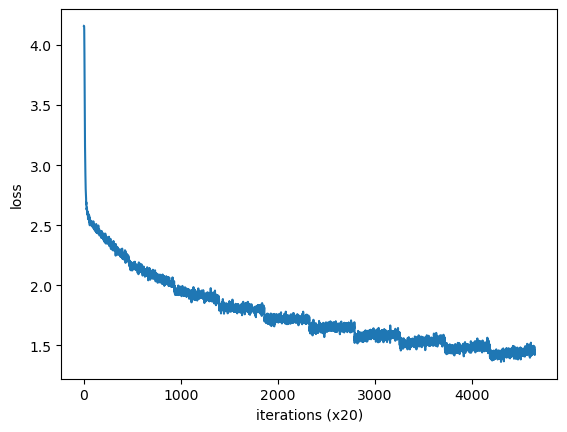

NameError: name 'word_veccs' is not defined

In [17]:
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target
from common.layers import SigmoidWithLoss
from dataset import ptb


window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
prarams = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [19]:
word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [20]:
from common.util import most_similar, analogy


pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.7099609375
 i: 0.697265625
 they: 0.61474609375
 your: 0.6083984375
 anything: 0.56103515625

[query] year
 month: 0.83154296875
 spring: 0.7744140625
 summer: 0.77197265625
 week: 0.7529296875
 decade: 0.7080078125

[query] car
 auto: 0.58642578125
 luxury: 0.57080078125
 truck: 0.5703125
 cars: 0.564453125
 window: 0.56298828125

[query] toyota
 honda: 0.67138671875
 mazda: 0.623046875
 seita: 0.62060546875
 f-14: 0.60546875
 minicomputers: 0.603515625


In [21]:
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 woman: 5.44921875
 a.m: 4.8046875
 wife: 4.68359375
 mother: 4.640625
 toxin: 4.515625

[analogy] take:took = go:?
 eurodollars: 5.17578125
 went: 4.328125
 came: 4.0859375
 're: 4.07421875
 hour: 3.984375

[analogy] car:cars = child:?
 a.m: 6.6015625
 rape: 5.5546875
 bond-equivalent: 5.12890625
 children: 5.109375
 adults: 5.0625

[analogy] good:better = bad:?
 rather: 6.046875
 more: 5.46875
 less: 5.17578125
 greater: 4.73828125
 faster: 3.890625


# 4.4 word2vec 남은 주제